In [1]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

ratings = pd.read_csv(os.path.join('data', 'data.txt'), sep='\t', header=None, names=['User ID', 'Movie ID', 'Rating'])

# Read in information on movies
names = ['Movie ID', 'Movie Title', 'Unknown', 'Action',
         'Adventure', 'Animation', 'Children\'s', 'Comedy',
         'Crime', 'Documentary', 'Drama', 'Fantasy',
         'Film-Noir', 'Horror', 'Musical', 'Mystery',
         'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(os.path.join('data', 'movies.txt'), sep='\t', header=None, encoding='latin_1', names=names)
movies['Movie Title'] = movies['Movie Title'].str.strip()

savefig_kwargs = {'dpi': 200, 'bbox_inches': 'tight', 'transparent': True}
plt.rc('pdf', fonttype=42)
#%config InlineBackend.figure_format = 'pdf'
%config InlineBackend.print_figure_kwargs = savefig_kwargs

In [2]:
# Separate movie name and year if desired
split_year = False
if split_year:
    movies.loc[266, 'Movie Title'] = 'unknown (0000)'
    movies.loc[1411, 'Movie Title'] = \
        'Land Before Time III: The Time of the Great Giving (V) (1995)'
    movies['Year'] = [int(title[-5:-1]) for title in movies['Movie Title']]
    movies['Movie Title'] = [title[:-7] for title in movies['Movie Title']]

In [3]:
# Merge ratings data with movie metadata
pdData = ratings.merge(movies, how='left', on='Movie ID')
data = np.random.permutation(pdData)

In [4]:
trainData = data[0: 900]
testData = data[900:]

In [5]:
from prob2utils_YM import train_model, get_err

In [6]:
M = max(max(trainData[:,0]), max(testData[:,0])) # users
N = max(max(trainData[:,1]), max(testData[:,1])) # movies
print("Factorizing with ", M, " users, ", N, " movies.")


Factorizing with  943  users,  1682  movies.


In [7]:
import matplotlib.pyplot as plt

regs = np.logspace(-4, 1, 16)
Ks = [2, 5, 10, 15, 20, 30, 40]

trainLosses = np.zeros((len(regs), len(Ks)))
testLosses = np.zeros((len(regs), len(Ks)))

for idx, reg in enumerate(regs):
    for jdx, K in enumerate(Ks):
        U, V, loss = train_model(M, N, K, 0.03, reg, trainData[:, 0:3], eps=1e-10, max_epochs=300)
        testLosses[idx, jdx] = get_err(U, V, testData[:, 0:3])
        trainLosses[idx, jdx] = loss

Normal stop at 300
early stop at 294
early stop at 210
early stop at 116
early stop at 113
early stop at 54
early stop at 50
Normal stop at 300
early stop at 292
early stop at 220
early stop at 111
early stop at 94
early stop at 62
early stop at 39
Normal stop at 300
early stop at 238
early stop at 167
early stop at 134
early stop at 87
early stop at 54
early stop at 37
Normal stop at 300
early stop at 243
early stop at 149
early stop at 93
early stop at 81
early stop at 49
early stop at 40
Normal stop at 300
early stop at 208
early stop at 129
early stop at 92
early stop at 65
early stop at 43
early stop at 37
Normal stop at 300
early stop at 176
early stop at 104
early stop at 78
early stop at 54
early stop at 46
early stop at 34
early stop at 224
early stop at 113
early stop at 78
early stop at 66
early stop at 48
early stop at 35
early stop at 29
early stop at 180
early stop at 93
early stop at 72
early stop at 57
early stop at 48
early stop at 34
early stop at 30
early stop at 118

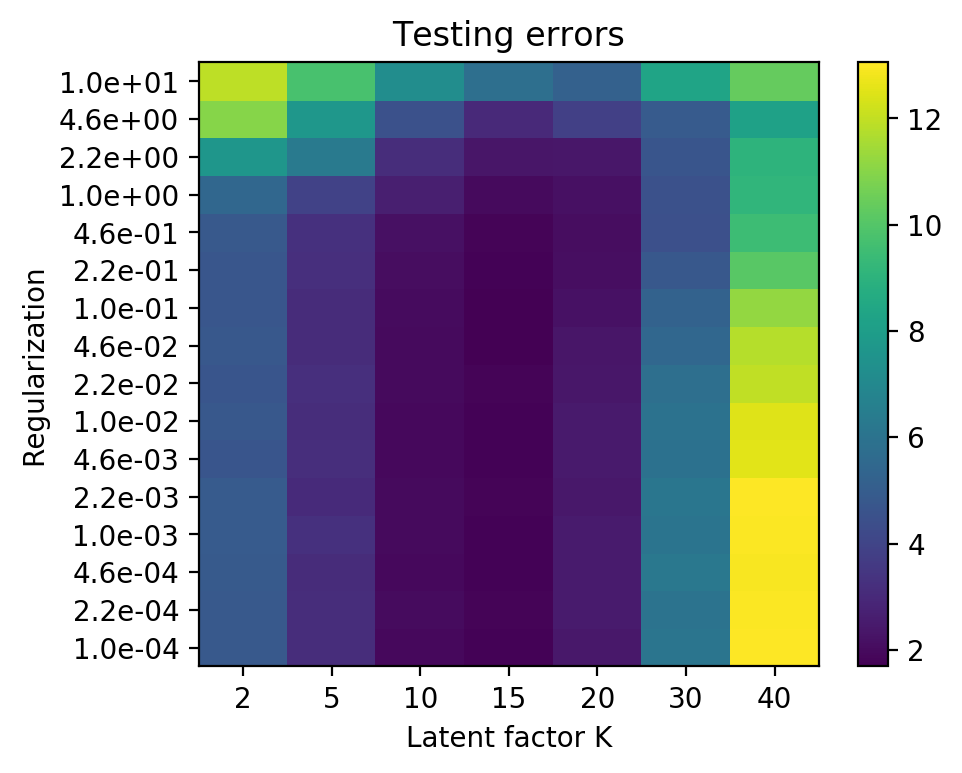

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
heatmap = ax.pcolor(testLosses)
ax.set_title('Testing errors')
ax.set_xlabel('Latent factor K')
ax.set_ylabel('Regularization')
ax.set_yticks(np.arange(testLosses.shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(testLosses.shape[1]) + 0.5, minor=False)

ax.set_xticklabels(Ks, minor=False)
ax.set_yticklabels(['{0:.1e}'.format(a) for a in regs], minor=False)

fig.colorbar(heatmap)

plt.show()

In [96]:
K = 15
U, V, loss = train_model(M, N, K, 0.03, regs[-5], trainData[:, 0:3], eps=1e-10, max_epochs=300)
print('testing error is: {0:.2f}'.format(get_err(U, V, testData[:, 0:3])))

early stop at 14
testing error is: 1.74


In [97]:
u, s, vh = np.linalg.svd(V)
reduK = 15
simV = V
# simV = u[:, :reduK] * s[0 :reduK] @ vh[:reduK, :reduK]

In [98]:
# simV - V

In [99]:
totRate = np.zeros(len(movies))
numRate = np.zeros(len(movies))
for y in data:
    totRate[y[1] - 1] += y[2]
    numRate[y[1] - 1] += 1
    
avgRate = totRate/numRate

In [100]:
rMovies = movies
rMovies['Average Rating'] = avgRate
genres = movies.columns[2:]

coefs = np.zeros((len(genres), simV.shape[1]))

for i in range(len(genres)):
    for j in range(simV.shape[1]):
        coef = np.corrcoef(np.array(movies.iloc[:, i + 2]), simV[:, j])[0, 1]
        coefs[i, j] = coef

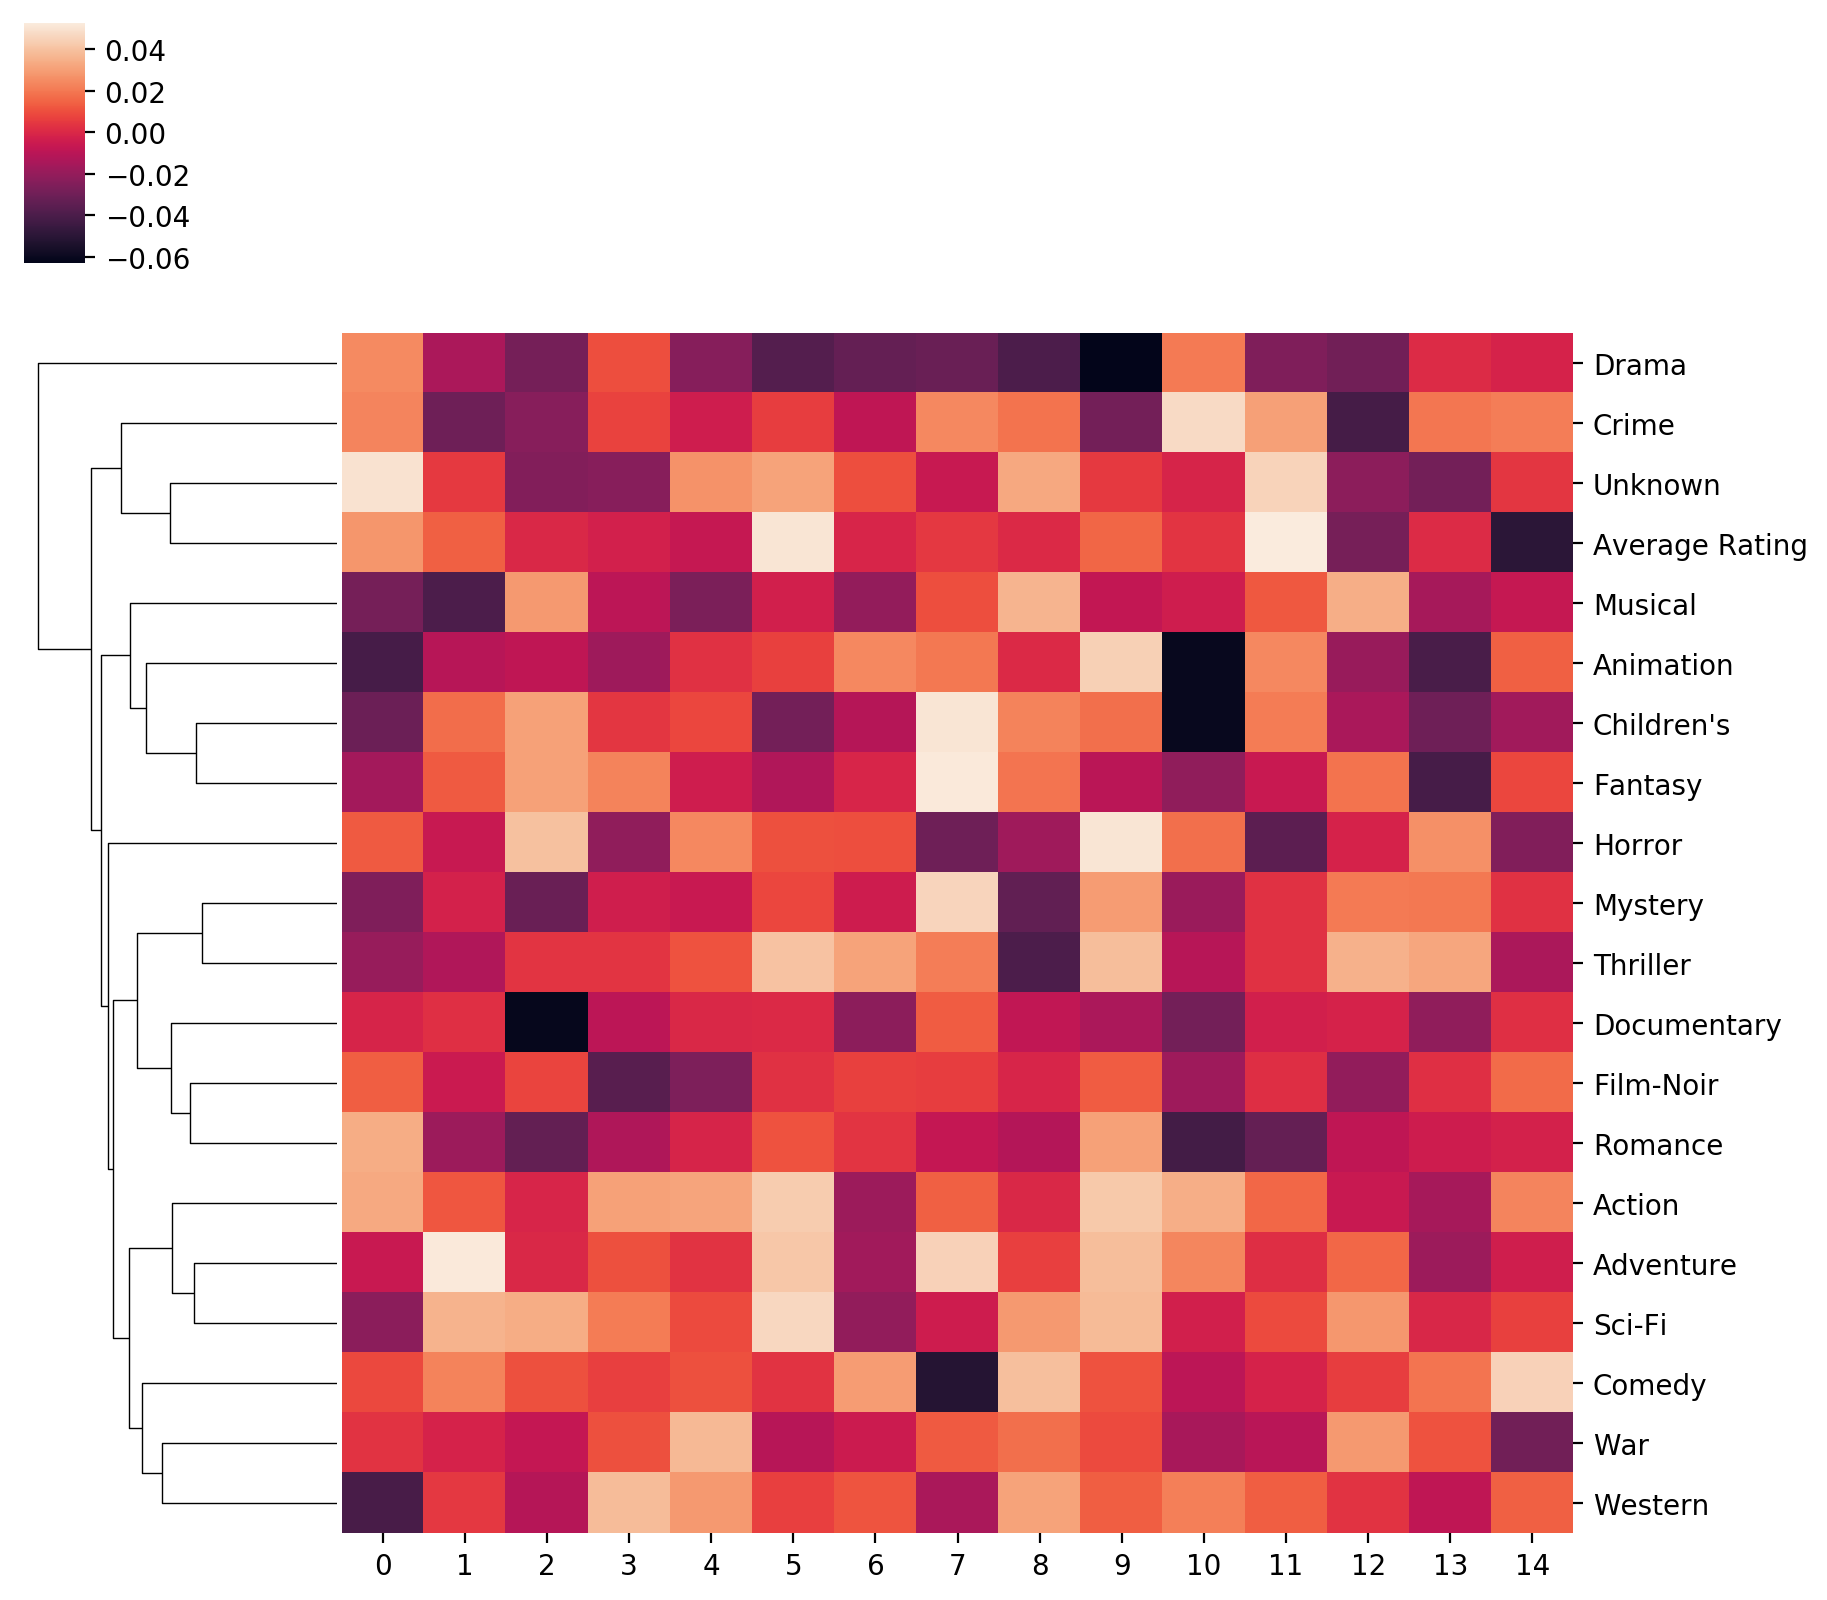

In [101]:
import seaborn as sns
pdCoefs = pd.DataFrame(coefs, index=genres)
sns.clustermap(pdCoefs, col_cluster=False, method='average')

In [63]:
simV.shape

(1682, 15)

In [89]:
np.array(movies.iloc[:, i + 2])

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [154]:
movies

,Movie ID,Movie Title,Unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Average Rating
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,3.878319
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,3.206107
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,3.033333
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.550239
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,3.302326
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.576923
6,7,Twelve Monkeys (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3.798469
7,8,Babe (1995),0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,3.995434
8,9,Dead Man Walking (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.896321
9,10,Richard III (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,3.831461
